In [62]:
import pandas as pd
import numpy as np

import umap
import hdbscan

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

import matplotlib.pyplot as plt

In [63]:
# Load data
df = pd.read_csv("C:/Users/HELIOS-300/Desktop/MATLAB/NasaDataCapstone/data/features.csv")

# Separate metadata and features
file_names = df["file_name"]
X = df.drop(columns=["file_name"])

In [64]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# # Optional: remove near-constant features
# X_scaled = VarianceThreshold(threshold=1e-3).fit_transform(X_scaled)

# Fit UMAP
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42
)

X_umap = umap_model.fit_transform(X_scaled)


c:\Users\HELIOS-300\Desktop\MATLAB\NasaDataCapstone\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [65]:
# Fit HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15, # larger -> fewer, more conservative clusters
    min_samples=5, # larger -> more points labled as noise
    metric="euclidean"
)

labels = clusterer.fit_predict(X_umap)

# Attach cluster labels
df["cluster"] = labels


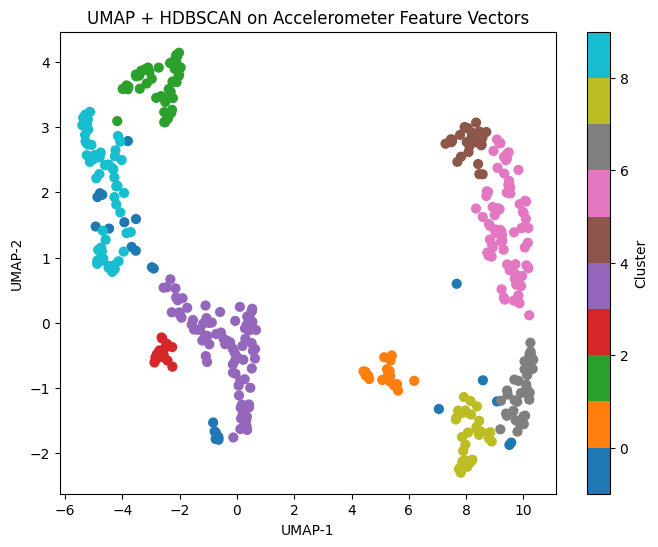

In [66]:
# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=labels,
    cmap="tab10",
    s=40
)
plt.colorbar(label="Cluster")
plt.title("UMAP + HDBSCAN on Accelerometer Feature Vectors")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()
